# Quantization
```{eval-rst}
.. index:: ! quantization
```
If you recall the introduction to this chapter, we saw that digitized audio has two properties: the *sampling rate* (already covered in this chapter), and the *precision*.  This section concerns the *precision* of digital audio, but what exactly does this mean?
To understand this, we'll first need to take a detour to see how computers represent numerical data.

## Background: digital computers and integers
```{eval-rst}
.. index:: binary numbers, two's complement
```
These days, most humans use the Hindu-Arabic (or *decimal*) numeral system to represent numbers.
With decimal digits, we use the ten symbols $0,1,2,\cdots,9$ to encode numbers as combinations of powers of ten (the *base* or *radix* of the system).
For example, a number like $132$ can be expanded out in terms of powers of 10:

$$
132= \red{1} \cdot 10^2 + \red{3} \cdot 10^1 + \red{2} \cdot 10^0.
$$

There's nothing magical about the number 10 here: it was probably chosen to match up with the number of fingers (ahem, *digits*) most people possess.
Any other *base* can work too.

Of course, computers don't have fingers, so they might find decimal to be difficult.
Computers do have logic gates though, which can represent *true* and *false* values, which we can interpret as $1$ and $0$ respectively.
This leads us to *binary* numbers, which only use two symbols to encode numbers as combinations of powers of 2, rather than combinations of powers of 10.

In our example above, the number $132$ could be represented as


\begin{align*}
132 &= \red{1} \cdot 128 + \red{0} \cdot 64 + \red{0} \cdot 32 + \red{0} \cdot 16 + \red{0} \cdot 8 + \red{1} \cdot 4 + \red{0} \cdot 2 + \red{0} \cdot 1\\
&= \red{1} \cdot 2^7 + \red{0} \cdot 2^6 + \red{0} \cdot 2^5 + \red{0} \cdot 2^4 + \red{0} \cdot 2^3 + \red{1} \cdot 2^2 + \red{0} \cdot 2^1 + \red{0} \cdot 2^0,
\end{align*}

or, more compactly, as $10000100_2$ (where the subscript lets us know we're in binary).
We refer to each position as a **bit** (short for **b**inary dig**it**).

`````{margin}
````{tip} Binary numbers in Python
Sometimes it's handy to encode binary numbers directly into Python code.
You can do this by prefixing the bits with `0b`.
For example:
```python
# x = 132
x = 0b10000100  
```
````
`````

For various technical reasons, computers don't generally support arbitrarily large numbers.
Instead, integers come in a few different "sizes" depending on how many bits we'll need: usually, 8, 16, 32, or 64 bits.
The example above is an *8-bit number*, but it could just as easily have been written in 16-, 32- or 64-bit representation by using leading zeros:
$0000000010000100_2$ for 132 in 16-bit form.

In [5]:
%run ../setup.ipynb

### Negative numbers

An $n$-bit number can represent $2^n$ distinct numbers, but *which numbers*?
We can interpret the bit representation as the numbers $0, 1, \cdots, 2^n-1$, but this doesn't provide an obvious way to represent *negative numbers*.

There's an elegant solution to this problem if we imagine arranging binary numbers around a circle, as illustrated below for 3-bit numbers.
We can think of counter-clockwise movement as *incrementing* by one, and clockwise movement as *decrementing* by one.
In this view, the numbers beginning with 1 can be seen as negative numbers: $111 = -1, 110 = -2, \dots$, and the numbers beginning with 0 are the non-negative numbers as discussed above.
It's beyond our scope here, but this representation of integers, known as [two's complement](https://en.wikipedia.org/wiki/Two%27s_complement), has many nice properties, and is implemented by almost every modern computer for doing integer arithmetic.

<Figure size 800x533.333 with 1 Axes>

<Figure size 800x533.333 with 1 Axes>

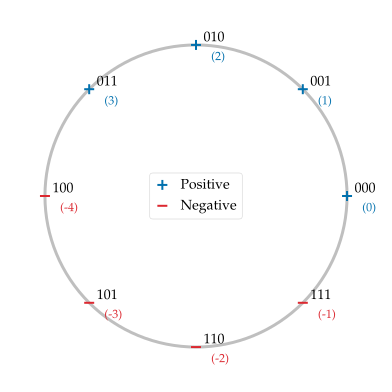

In [6]:
fig, ax = plt.subplots(figsize=figaspect(2./3))

angles = np.linspace(0, 2 * np.pi, num=8, endpoint=False)
circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, alpha=0.25, fill=False, zorder=-1)
ax.scatter(np.cos(angles[:4]), np.sin(angles[:4]), color=colors[0], label='Positive', marker='+', s=100)
ax.scatter(np.cos(angles[4:]), np.sin(angles[4:]), color=colors[1], label='Negative', marker='_', s=100)
ax.legend(loc='center')

for i in range(8):
    ax.text(np.cos(angles[i]) + 0.05, np.sin(angles[i]) + 0.025, '{:03b}'.format(i))
    if i < 4:
        ax.text(np.cos(angles[i]) + 0.1, np.sin(angles[i]) - 0.1, '({:d})'.format(i), size=12, color=colors[0])
    else:
        ax.text(np.cos(angles[i]) + 0.1, np.sin(angles[i]) - 0.1, '(-{:d})'.format(8-i), size=12, color=colors[1])
        
ax.add_patch(circ)
ax.axis('off')
ax.set_aspect('equal')
ax.set_xlim([-1.25, 1.25])
ax.set_ylim([-1.25, 1.25]);
ax.set_xticks([])
ax.set_yticks([]);
glue('2scomp', fig, display=False)

```{glue:figure} 2scomp
:alt: Visualization of two's complement for 3-bit integers

Two's complement representation of 3-bit integers (-4, -3, …, 3).
```

To summarize, an $n$-bit two's-complement integer can represent $2^{n-1}$ distinct non-negative numbers ($0, 1, \dots, 2^{n-1}-1$), and $2^{n-1}$ distinct negative numbers ($-1, -2, \dots, -2^{n-1}$).
For example, an 8-bit number can take $2^8 = 256$ distinct values: $-128, -127, \dots, -2, -1, 0, 1, 2, \dots, 127$.

This is a relatively minor detail in the bigger picture of digital signals, but it can help to understand why quantized signals look the way they do (as illustrated below).

## Defining precision and quantization
```{eval-rst}
.. index:: ! precision, ! bit depth
```
**Precision**, also known as **bit depth**, refers to how many *bits* are used to represent each sample in a digital signal.
While we typically think of signals as taking on continuous real values, computers **quantize** these values to be drawn from a fixed, finite set of numbers.

High precision means that we have more distinct values, and can therefore faithfully represent smaller differences and get a more accurate representation of the underlying continuous signal.
However, doing so comes at a cost: higher precision means we're storing and transmitting more data.
There's a trade-off to be made between storage cost and the perceptual fidelity of the quantized signal.
Investigating this thoroughly is beyond the scope of this text, but interested readers are encouraged to look into *perceptual coding* and *lossy audio compression* to learn more.

## The effects of quantization

{numref}`quantization-animation` illustrates the effects of varying levels of quantization on samples from a continuous waveform.
High precision values (16-bit) provide a good approximation to the original wave, but this approximation deteriorates as we reduce the precision.
In the extreme case (1-bit quantization), each sample can take only one of two values (-1 or 0), which results in a highly distorted signal.

In [7]:
## This function is defined, but hidden here, since we use it for the animation.
# We'll redefine it inline of the text when it's appropriate to do so.
def quantize(x, n_bits):
    
    # Specify our quantization bins: 
    #   2^n_bits values, evenly (linearly) spaced 
    # between the min and max of the input x
    bins = np.linspace(x.min(), x.max(), 
                          num=2**n_bits, 
                          endpoint=False)
    
    # Quantize x
    return np.digitize(x, bins)

<Figure size 800x600 with 6 Axes>

<Figure size 800x600 with 6 Axes>

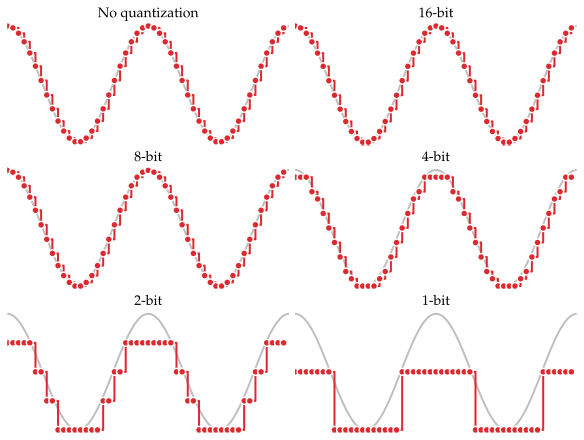

In [18]:
#%%capture
# Animations for changing quantization levels


t_high = np.linspace(0, 1, num=1000, endpoint=False)
freq = 2
cont_wave = np.cos(2 * np.pi * freq * t_high)

t_samp = np.linspace(0, 1, num=50, endpoint=False)
samp_inf = np.cos(2 * np.pi * freq * t_samp)

samp_16 = (quantize(samp_inf, 16) - 2**15 -1) * 2.0**(-15)
samp_8 = (quantize(samp_inf, 8) - 2**7-1) * 2.0**(-7)
samp_4 = (quantize(samp_inf, 4) - 2**3-1) * 2.0**(-3)
samp_2 = (quantize(samp_inf, 2) - 2**1-1) * 2.0**(-1)
samp_1 = (quantize(samp_inf, 1) - 2**0-1) * 2.0**(0)

samp_wave = samp_inf

fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(8, 6))

for _ax in ax.flat:
    _ax.plot(t_high, cont_wave, color='k', alpha=0.25)
    _ax.label_outer()
    
ax[0, 0].step(t_samp, samp_wave, color=colors[1], where='post', marker='o')
ax[0, 0].set(title='No quantization')
ax[0, 1].step(t_samp, samp_16, color=colors[1], where='post', marker='o')
ax[0, 1].set(title='16-bit')
ax[1, 0].step(t_samp, samp_8, color=colors[1], where='post', marker='o')
ax[1, 0].set(title='8-bit')
ax[1, 1].step(t_samp, samp_4, color=colors[1], where='post', marker='o')
ax[1, 1].set(title='4-bit')
ax[2, 0].step(t_samp, samp_2, color=colors[1], where='post', marker='o')
ax[2, 0].set(title='2-bit')
ax[2, 1].step(t_samp, samp_1, color=colors[1], where='post', marker='o')
ax[2, 1].set(title='1-bit')

ax[0, 0].set_ylim([-1.05, 1.05])
ax[0, 0].set(xticks=[], yticks=[], ylim=[-1.05, 1.05])

glue('quantization', fig, display=False);

```{glue:figure} quantization
---
name: quantization-animation
alt: Illustrration of how quantized sample values differ from the underlying continuous signal at different bit depths
---

A continuous signal (solid curve) is sampled (dots) and then quantized to several different bit depths.
At low depths, the sample values are noticeably different from the original signal.
```

## Dynamic range
```{eval-rst}
.. index:: ! dynamic range
```
Fundamentally, quantization reduces the number of distinct values that can be observed in a signal.
Rather than the full range of continuous values, say voltages in the range $[-V, +V]$, we instead divide up the range into pieces of constant (quantized) value.
For uniform quantization into a $n$-bit integer representation, we have $2^n$ distinct numbers representing different values between $-V$ and $+V$.
If $q$ represents an $n$-bit quantized integer value $-2^{n-1} \leq q \leq 2^{n-1}-1$, then we can map $q$ to a value $v(q)$:
```{math}
:label: unquantize

v(q) = V \cdot \left(\frac{q}{2^{n-1}}\right),
```
as illustrated in {numref}`quantization-animation`.
This process is lossy, in that not every continuous input value can be realized by a specific quantized number $q$, and this fact raises many questions about how accurate the quantization process is.

We won't go into all the details of analyzing quantization error, but one commonly used method to evaluate a quantization scheme is to measure its **dynamic range**: the ratio of its loudest value $v_+$ to its quietest (non-zero) value $v_-$, measured in decibels.
Typically, the values in question are voltages, which you may recall from [chapter 1](pressure-intensity) are proportional to sound pressure, and that intensity is proportional to the *square* of pressure (and therefore, the square of voltage).
As a result, to compute dynamic range $R_\text{dB}$ for quantized voltages, we'll need to square them:

```{math}
:label: dynamic-range-db

R_\text{dB} = 10 \cdot \log_{10} \left(\frac{v_+}{v_-}\right)^2 = 20 \cdot \log_{10} \frac{v_+}{v_-}.
```

To use this idea, we'll need to calculate the smallest and largest (absolute) values attainable by {eq}`unquantize`.
The smallest value, $v_-$ is attained by $q=1$, so that
```{math}
v_- = v(1) = V \cdot \left(\frac{1}{2^{n-1}}\right).
```
The largest absolute value, $v_+$, is attained by $q= -2^{n-1}$:
```{math}
v_+ = \left|v\left(-2^{n-1}\right)\right| = V \cdot \left(\frac{2^{n-1}}{2^{n-1}}\right).
```
When we form the ratio $v_+ / v_-$, note that there is a common factor of $V / 2^{n-1}$ that can be cancelled, resulting in:
```{math}
\frac{v_+}{v_-} = 2^{n-1}.
```
Plugging this value into {eq}`dynamic-range-db` yields

```{math}
:label: dr-quantization

\begin{aligned}
R_\text{dB} &= 20 \cdot \log_{10} 2^{n-1}\\
              &= (n-1) \cdot 20 \log_{10} 2\\
              &\approx (n-1) \cdot 6.02~[\text{dB}]\\
\end{aligned}
```

```{tip}
Equation {eq}`dr-quantization` gives rise to a commonly used rule of thumb: each bit of precision adds about 6 dB of dynamic range.
```

````{margin}
```{warning}
Note that dynamic range is not to be confused with *signal-to-noise ratio (SNR)*, which is also often reported as a measure of quantization quality, but a bit more involved to calculate.
```
````

Equation {eq}`dr-quantization` allows us to measure the dynamic range purely as a function of bit depth.
The following table gives dynamic range values for several common choices of $n$.
```{list-table}
:header-rows: 1

* - Precision [bits]
  - Dynamic range [dB]
* - $n=1$
  - 0.0
* - $n=2$
  - 6.02
* - $n=4$
  - 18.06
* - $n=8$
  - 42.14
* - $n=16$ (compact disc standard)
  - 90.31
* - $n=24$
  - 138.47
* - $n=32$
  - 186.64
```

## Floating point numbers
```{eval-rst}
.. index:: floating point
```
The integer quantization scheme described above is commonly used for storing audio signals (e.g., in `.wav` format), but it is sometimes not the most convenient representation for *processing* audio signals.
Instead, most computers use **floating point** representations for numerical data, and have dedicated hardware for carrying out mathematical operations on floating point numbers.
Floating point numbers differ from integer representations in several key ways, but they are the standard choice for representing fractional numbers and (approximately) continuous values.
This is achieved by using a *non-uniform* spacing of numbers encoded in a format similar to scientific notation.
Note that floating point numbers are still technically quantized, but the quantization level is practically so small that we treat them as though they were not quantized at all.

Floating point representations are defined by the [IEEE 754 standard](https://en.wikipedia.org/wiki/IEEE_754), which is quite a bit more detailed than we need to get into here.
Rather than calculate the minimum and maximum values from the specification---which is doable, but tedious---we'll instead see how to retrieve this information from the computer directly.

Like most numerical computation libraries, Numpy provides an interface for getting information about the number representations used behind the scenes.
For floating point numbers, this is provided by the [`np.finfo`](https://numpy.org/doc/stable/reference/generated/numpy.finfo.html) function.
This function accepts as input a data type (e.g., `np.float32` for 32-bit floating point), and returns an object containing various constants such as the largest and smallest numbers that can be represented.
The code fragment below shows how to use this information, combined with {eq}`dynamic-range-db` to compute the dynamic range for 32-bit floats.

In [17]:
# Get the floating point information from numpy
print('32-bit floating point\n')
float32_info = np.finfo(np.float32)
print('Smallest value:\t ', float32_info.tiny)
print('Largest value:\t ', float32_info.max)

# Compute the dynamic range by comparing max and tiny
dynamic_range = 20 * (np.log10(float32_info.max) - np.log10(float32_info.tiny))
print('Dynamic range:\t {:.2f} [dB]'.format(dynamic_range))

32-bit floating point

Smallest value:	  1.1754944e-38
Largest value:	  3.4028235e+38
Dynamic range:	 1529.23 [dB]


Compared to the integer representations listed above, 32-bit floats provide a substantially higher dynamic range
Given the same amount of storage (32 bits), integers have a dynamic range of about 186 dB, compared to floats with 1529!
This is far in excess of the dynamic range of human hearing, and often perfectly adequate for most signal processing applications.
However, if for some reason 1529 decibels is not enough, we can repeat this calculation for 64-bit floats (sometimes called *double precision*).

In [22]:
# Repeat the above, but for 64-bit floats
print('64-bit floating point\n')

float64_info = np.finfo(np.float64)
print('Smallest value:\t ', float64_info.tiny)
print('Largest value:\t ', float64_info.max)

dynamic_range = 20 * (np.log10(float64_info.max) - np.log10(float64_info.tiny))
print('Dynamic range:\t {:.2f} [dB]'.format(dynamic_range))

64-bit floating point

Smallest value:	  2.2250738585072014e-308
Largest value:	  1.7976931348623157e+308
Dynamic range:	 12318.15 [dB]


On most modern computers and programming environments, 64-bit floating point is the default numerical representation unless you specifically request something else.
All of the "continuous-valued" examples in this book use 64-bit floating point.
However, many digital audio workstations (DAWs) and other audio processing software will provide the option to use 32-bit floating point because it reduces the amount of storage and computation necessary, and is still sufficient for most use cases.

## But what does it sound like?

We can simulate quantization numerically by defining a ``quantize`` function as below.
We'll then be able to synthesize a pure tone, and hear how it sounds when quantized to varying bit depths.

**Warning**: the lower bit depths can sound quite harsh.

(quantize-function)=

In [2]:
import numpy as np
from IPython.display import display, Audio

def quantize(x, n_bits):
    '''Quantize an array to a desired bit depth
    
    Parameters
    ----------
    x : np.ndarray, The data to quantize
    n_bits : integer > 0, The number of bits to use per sample
        
    Returns
    -------
    x_quantize : np.ndarray
        x reduced to the specified bit depth
    '''
    # Specify our quantization bins: 
    #   2^n_bits values, evenly (linearly) spaced 
    # between the min and max of the input x
    bins = np.linspace(x.min(), x.max(), 
                          num=2**n_bits, 
                          endpoint=False)
    return np.digitize(x, bins)

# We'll make a 1-second example tone at 220 Hz
duration = 1
fs = 11025
freq = 220

t = np.arange(duration * fs) / fs  # Our sample times
x = np.cos(2 * np.pi * freq * t)  # The continuous signal

display('Original signal (float64)')
display(Audio(data=x, rate=fs))

# And play the audio at each bit depth
for bits in [16, 8, 4, 2, 1]:
    display('{}-bit'.format(bits))
    display(Audio(data=quantize(x, bits), rate=fs))

'Original signal (float64)'

<source src="data:audio/wav;base64,UklGRkZWAABXQVZFZm10IBAAAAABAAEAESsAACJWAAACABAAZGF0YSJWAAD/f/1+/nsMdztwqGd0XchR1ETLNuYnYBh5CHD4hej42AjK8bvsriyj4pg2kEuJPYQhgQKA5oDJg5+IVY/Ql+2hha1oumLIPde75p72pwaVFikmJDVJQ19QM1yTZlhvXXaHe8B++380f258tHcZcbdosF4tU1xGbzigKSoaSgpC+lHqttqxy369V7BwpPmZHJH8ibeEYoEJgLOAXIP6h3uOw5azoCKs4ri/xoPV8uTN9NQEyRRrJHozukHyTuxaemVvbqh1CXt7fvF/ZX/YfFZ48XHBaehfjlTgRxE6WSvyGxsMFfwd7HXcXM0Pv8exuaUVmwiStIo4hamBFoCFgPWCW4emjbyVfp/Dql+3H8XM0yrj/PICA/wSqiLNMSdAgE2hWVpkgG3udIV6MX7hf49/PH3yeMJyxWobYepVYEmwOw8tuR3sDej96+033gvPo8A6swanN5z6knKLv4X3gSqAX4CUgsKG14y7lE6eaanhtYLDF9Jk4SzxLwEuEeggHjCSPgtMUlg2Y4tsLXT7ed99yX+yf5l9iHmOc8RrSGJCV91KSz3DLn4fvA+6/7rv+t+70DrCsrRYqF6d8ZM2jEyGTIJFgD+AO4Iwhg6Mv5MjnRSoZrTpwWTQoN9d713/Xw8kH2wu+TyRSv5WDGKRa2ZzanmHfat/zn/wfRd6VHS9bHFjlVhWTOM+dDBCIYoRjAGJ8b/hbtLVwy22rqmKnu6UAI3ghqeCZoAmgOeBpIVMi8mS/ZvDpvCyUsC0zt3dju2K/Y8NXh23LF07FEmlVd5gkWqZctR4KX2Hf+R/QH6gehN1sG2UZORZyk14QCMyBCNYE18DWfOF4yTUcsWstwmru5/wldCNeocJg46AE4CagR6Fj4rYkdyadqV9sb++B80c3MHruPu+C5cbASu+OZNHSFSqX4xpxnE2eMR8XH/0f4p+I3vNdZ5usmUuWztPCkLPM8QkJRUyBSr1TeXb1RPHL7lorPGg+ZamjhuIcYO8gAeAVIGehNiJ7ZDBmS+kDrAvvVzLXdr16eX57QnPGUgpHDgORuZScl6BaO1wk3dYfCp//H/Mfp97gXaGb8tmc1yoUJhDeTWCJvEWBAf89hbnlde3yLa6zK0togaYgo/BiOCD8YACgBWBJYQoiQiQqpjsoqSuoru0yZ/YKegT+BwIBRiNJ3c2hUSAUTRdcWcOcOl25nvxfv5/CX8VfC53aHDfZ7RdEFIjRR83Pii8GNYIzfjh6FHZXcpAvDSvbaMZmWOQbolVhC2BA4DbgLODfogpj5qXrqE9rRm6Dsjk1l/mQfZJBjkW0CXPNPlCFlDyW1tmKm86dm57sn76fz9/hHzVd0Vx7WjvXnRTqkbDOPkphRqnCqD6reoP2wbMzr2gsLGkMZpLkSGK0YRvgQuAqYBHg9qHUI6OlnWg26uUuGzGK9WX5HD0dwRtFBEkJDNqQahOqlpBZUBuhHXvem1+7n9uf+18dngbcvVpJmDUVC1IZDqxK00ceAxy/Hnsz9yyzWC/EbL7pU+bOJLailKFuIEagH2A4YI8h3yNiJVBn36qE7fNxHTTz+Kf8qQCoBJQIncx1z82TV9ZIGRQbch0anohftx/ln9PfRF57HL4alhhL1atSQI8Zi0UHkkORf5H7pHeYc/0wIWzSadynCuTmYvbhQiCL4BYgIKCpIaujIiUEp4lqZW1MMPA0Qnhz/DSANEQjiDHL0A+v0sOWPtiWmwFdN95zn3Ef7h/q32lebZz9muEYoZXKUudPRkv2R8YEBcAFvBU4BLRjML9tJyomp0jlF6MaYZegkuAOYApghOG54uNk+ic0KcbtJfBDtBF3wDvAP8CD8keFS6nPEVKuVbQYV9rPXNNeXV9pX/TfwB+M3p7dO5srGPZWKBMND/KMJwh5xHqAebxGuLF0ifEebbzqceeIZUpjf6GuoJtgCGA14GIhSWLmJLDm4CmpbIBwF7Og90y7S39Mg0DHWAsCjvHSF9VoWBeam9ytXgVfX9/6H9Pfrt6OXXgbc5kJloUTslAeTJeI7UTvAO28+Dje9TFxfm3T6v5nyWW+o2ahx2Dl4AQgIyBBIVqiqmRo5o1pTOxbr6xzMLbZeta+2ELPBupKmo5RUcBVGxfV2mbcRZ4r3xSf/Z/l348e/J1zW7rZW9bhE9aQiQ0HSWBFY8Fh/Wo5TTWZ8d9ua+sMKEul9GOO4iHg8aABoBHgYaEtYm/kImZ7qPFr9+8B8sD2pnpiPmQCXMZ8CjIN79Fn1IyXktowXByd0J8H3/9f9l+t3ukdrRvA2e0XPBQ50PNNdsmTRdhB1n3cufu1wvJBbsUrmyiPZiuj+OI94P9gAKACYEOhAWJ249zmKyiXK5Tu1/JR9jO57b3vgepFzQnIjY2RDhR9Fw6Z+Fvx3bPe+V+/n8Ufyx8UHeVcBVo811YUnFFdDeXKBgZMwkr+T3pqtmyypC8fa+to1GZkZCRiW2EOoEEgNGAnYNciP2OZJdvofasy7m6x4zWBObk9ewF3RV3JXo0qULNT7FbI2b8bhZ2VXulfvh/SX+afPZ3cHEiaS5fu1P3Rhc5USrhGgQL/foJ62nbXMwevuqw86RqmnmRRYrqhH6BDoCggDKDuocljlmWN6CVq0e4GcbT1DvkE/QaBBEUtyPOMhlBXk5oWgdlEG5eddV6Xn7rf3Z/AX2VeEVyKmpjYBpVeki3OggsqBzVDND81uwp3QjOsL9bsj2miZtokv+KbYXIgR2AdYDOgh2HUo1VlQSfOKrGtnrEHdN04kPyRwJDEvYhITGGP+tMHFnmYx9toXRPehF+2H+ef2J9L3kVcyxrlGF0VvlJVDy9LW8epQ6i/qTu6963z0bB0LOMp62cXJPAi/eFGII0gFGAcIKHhoaMVZTWneCoSbXewmnRr+Bz8HQAdRAzIHAv7z10S8pXwGIobN5zwnm9fb5/vn+9fcJ53nMobMBiyld0S+89cC8zIHUQdABz8K/gadHewkm14KjWnVWUhoyHhnCCUYA0gBiC94XAi1yTrZyMp9CzRsG3z+vepO6i/qUObx69LVQ8+Ul0VpRhLGsVcy95Yn2ef9h/EX5PeqF0H23mYxxZ60yGPyEx9iFDEkcCQ/J04h3TesTGtjiqBJ9VlVKNHYfOgnWAHYDIgW2F/4pokombPaZbsrC/CM4p3dbs0PzVDKgcCCy3OnpIGlVjYCpqRXKVeAF9dn/rf15+1XpedRBuB2VoWl5OGUHOMrcjERQaBBP0O+TT1BnGR7iVqzegWZYljrqHMoOggA6AfoHqhEWKeZFqmvOk6rAevlzMadsJ6/36BAvhGlEqFzn3RrtTLl8iaXBx9neafEl/+H+lflV7Fnb8biNmsVvNT6lCejR3Jd0V7AXk9QTmjNa6x8u59qxvoWSX/Y5ciJ2D0YAEgDqBbYSRiZGQUZmto32vkLyyyqrZPekr+TMJGBmXKHQ3cUVYUvNdFWiVcFB3LHwUf/5/5X7Pe8d24W86Z/RcOFE2RCI2NCepF74HtvfO50fYX8lTu1yurKJzmNuPBYkOhAmBAoD9gPeD44iujz2YbKIUrgW7C8nu13LnWfdhB00X2ybNNedD8FC0XANntG+kdrd72X79fx9/Qnxyd8FwS2gyXp9Sv0XIN/AocxmQCYj5mekD2gfL37zFr+6jiZm/kLWJhoRHgQaAxoCHgzuI0Y4ulzChr6x9uWfHNNao5Yf1jwWBFR0lJDRaQoRPb1vrZc1u8nU8e5d+9n9Sf698FnibcVdpbF8BVEVHajmpKjwbYQta+2XrwtuxzG6+M7E1paOaqZFqigSFjIEQgJeAHYOah/qNJZb5n0+r+bfFxXvU4OO287wDtRNeI3kyyUAUTiZazmTgbTl1u3pPfuh/f38VfbV4b3JeaqFgX1XHSAo7YCwDH

'16-bit'

<source src="data:audio/wav;base64,UklGRkZWAABXQVZFZm10IBAAAAABAAEAESsAACJWAAACABAAZGF0YSJWAAD/f35//32Gex141HO6buRoaWJlW/JTL0w8RDc8QjR7LAMl+B11F5URcAwaCKQEHQKPAAAAcgDjAU4EqQfnC/UQwRYzHTAknStdM047U0NKSxRTkVqkYS9oGW5Jc6x3LnvDfWB//X+afzd+2nuMeFt0WG+WaS1jN1zQVBRNJEUgPSc1Wi3YJb4eKhg3EvsMjQj9BFoCsAADAFgArQH8AzwHYAtYEBAWcBxfI8EqeDJmOmlCZEo1UrxZ3GB4Z3ZtvHI3d9R6hH09f/h/sn9sfit8+HjgdPRvR2rvYwhdrFX4TQ1GCj4ONjourSaGH+IY2xKKDQMJWQWbAtMACgBBAHkBrAPSBt0Kvg9hFa8bjyLlKZQxfTmAQX1JVFHmWBNgwGbQbC1ywHZ3ekJ9GH/wf8d/nn55fGF5YnWNcPVqsGTXXYdW3E71RvM+9TYbL4QnUCCcGYITGg58CbgF3gL6ABQALgBJAWADagZcCiYPtBTvGsAhCymxMJU4l0CWSHNQDlhIXwVmKGybcUV2Fnr9fO9+5H/Zf8x+xHzHeeJ1JHGha25lpV5hV79P3UfcP9w3/C9dKBwhWBorFK4O9wkaBiUDJQEhAB4AHAEXAwYG3gmQDgkUMhrzIDEozy+uN64/r0eRTzVXfF5IZX5rBnHIdbN5tXzDftV/53/4fgt9KnpedrhxSmwqZnFfOVigUMVIxUDEON8wNinpIRUb1hRED3YKfwZvA1IBMgASAPIA0QKlBWMJ/Q1gE3cZKCBZJ+0uxjbEPsdGrk5bVq5diWTSam9wSHVMeWp8lH7Df/J/IH9QfYl62HZKcvJs5WY8YBFZgVGsSa9BrDnCMREquCLVG4MV3Q/3CucGvAODAUYACADMAI4CRgXrCG0NuhK9GF4fgiYNLuA12z3fRctNgFXeXMljI2rVb8Z043gbfGJ+rn/6f0V/kX3mek932XKXbZ1nBGHnWWFSkkqYQpQ6pjLtKogjlxwzFngQewtSBwwEtwFdAAIAqQBOAusEdQjfDBYSBhiWHq0lLS35NPI89kTnTKNUDVwGY3NpOG9AdHZ4yXssfpV//n9mf899QHvDd2VzOW5TaMthvFpBU3hLgUN9O4ozyitaJFod5RYVEQIMwAdfBO8BdwAAAIkAEQKTBAMIVAx1EVEX0B3ZJE8sFDQJPA1EAkzGUztbQmLAaJpuuHMHeHR78314f/9/hH8Kfpd7NHjvc9luCGmRYo9bH1RdTGpEZjxwNKgsLiUfHpkXtRGLDDAItgQpApUAAABsANgBPgSTB8wL1hCeFgwdBiRxKy8zIDskQxxL51JnWnxhC2j4bS1zlXcce7d9WX/9f59/Qn7qe6J4dnR3b7ppVGNhXPxUQk1TRU89VTWHLQIm5h5PGFgSGA2kCA8FZwK2AAQAUwCiAewDJwdGCzkQ7RVJHDUjlSpKMjc6O0I2SghSkVm0YFRnVW2gch93wnp3fTZ/93+3f3Z+O3wNefp0E3BqahZkMl3YVSZOO0Y4Pjw2Zy7YJq8fBxn8EqYNGwlsBagC2wAMAD0AbwGdA70GwwqfDz4ViBtlIrkpZzFPOVFBT0knUbtY61+aZq9sEHKndmN6NX0Qf+5/y3+nfoh8dXl8datwF2vWZAFes1YJTyRHIj8jN0gvryd5IMEZoxM4DpQJywXsAgMBFgArAEABUQNWBkMKCA+RFMkalyHfKIQwZzhoQGhIRlDjVyBf32UHbH1xLXYCeu98537if9x/1X7SfNt5+3VCccNrlGXOXoxX7E8LSAtACjgpMIgoRSF+Gk0UzA4QCi4GNAMuASQAGwATAQgD8gXFCXMO5xMMGsogBiiiL383fz+AR2RPCldTXiJlXGvocK91nnmmfLp+0n/pfwB/GX09end21XFsbFBmml9lWM1Q80j0QPI4DDFiKRMiPBv5FGIPjwqTBn4DXAE1AA8A6gDDApEFSwngDT8TURn/Hy4nwS6YNpY+mEaBTi9WhV1jZK9qUHAudTd5WnyKfr9/9H8nf119nHrwdmdyE20KZ2RgPFmuUdpJ3UHaOe8xPSriIvwbphX7DxEL/AbMA40BSgAHAMUAgQI0BdMIUA2ZEpgYNh9YJuAtsjWsPbBFnU1UVbVcomMAarZvq3TNeAt8V36pf/t/S3+effh6Znf1crdtwmcsYRJajlLASsdCwzrTMhkrsiO+HFcWlxCWC2cHHATCAWIAAQCiAEIC2QReCMMM9hHiF28egiUBLcs0wzzHRLlMd1TjW99iT2kZbyV0YHi4eyF+j3/+f2x/231Se9p3gXNZbnho82HmWm1TpkuwQ6w7uDP2K4QkgR0JFzURHQzWB3AE+gF9AAAAgwAGAoEE7Ac5DFURLRepHa8kIizmM9o73kPUS5pTEFsbYpxoem6dc/B3Y3vnfXJ//3+KfxV+qHtKeAp0+W4rabhiuVtLVItMmUSVPJ001CxYJUcevRfVEacMRwjHBDUCnAABAGcAzQEtBH0HsQu2EHoW5RzcI0UrATPxOvVC7kq7UjxaVGHmZ9htEXN9dwt7qn1Sf/x/pH9Nfvt7uHiRdJZv3Wl7Y4tcKFVwTYJFfj2DNbMtLSYOH3QYeBI0DbwIIQV0Ar4ABQBPAJgB3AMRBywLGhDJFSIcCyNpKh0yCToMQghK21FnWYxgL2c0bYNyCHevemp9L3/1f7t/gH5KfCJ5FHUxcIxqPWRbXQRWVE5qRmc+ajaULgMn1x8sGR4Tww0zCX4FtQLjAA0AOQBmAY0DqAapCoEPGxViGzwijSk5MSA5I0EhSfpQkFjCX3VmjWzzcY92UHonfQh/7H/Pf7F+l3yKeZV1ynA6a/xkKl7eVjdPUkdQP1E3dS/bJ6Ig5xnFE1UOrQnfBfoCCwEZACcANwFCA0IGKgrqDm8UoxpuIbMoVzA5ODlAOkgZULhX9166ZeVrX3EUdu954Xzeft9/33/efuF873kUdl9x5Wu6ZfdeuFcZUDpIOUA5OFcwsyhuIaMabxTqDioKQgZCAzcBJwAZAAsB+gLfBa0JVQ7FE+cZoiDbJ3UvUTdQP1JHN0/eVipe/GQ6a8pwlXWKeZd8sX7Pf+x/CH8nfVB6j3bzcY1sdWbCX5BY+lAhSSNBIDk5MY0pPCJiGxsVgQ+pCqgGjQNmATkADQDjALUCfgUzCcMNHhMsGdcfAyeULmo2Zz5qRlROBFZbXT1kjGoxcBR1InlKfIB+u3/1fy9/an2vegh3g3I0bS9njGBnWdtRCEoMQgk6HTJpKgsjIhzJFRoQLAsRB9wDmAFPAAUAvgB0AiEFvAg0DXgSdBgOHy0msy2DNX49gkVwTShVi1x7Y91plm+RdLh4+3tNfqR//H9Sf6p9C3t9dxFz2G3mZ1RhPFq7Uu5K9ULxOgEzRSvcI+Uceha2ELELfQctBM0BZwABAJwANQLHBEcIpwzVEb0XRx5YJdQsnTSVPJlEi0xLVLlbuGIrafluCnRKeKh7FX6Kf/9/cn/nfWN78Hedc3punGgbYhBbmlPUS95D2jvmMyIsrySpHS0XVRE5DOwHgQQGAoMAAAB9APoBcATWBx0MNREJF4EdhCT2K7gzrDuwQ6ZLbVPmWvNheGhZboFz2ndSe9t9bH/+f49/IX64e2B4JXQZb09p32LjW3dUuUzHRMM8yzQBLYIlbx7iF/YRwwxeCNkEQgKiAAEAYgDCARwEZweWC5cQVxa+HLIjGSvTMsM6x0LASo5SElosYcJnt231cmZ3+HqefUt/+3+pf1d+C3zNeKt0tm8AaqJjtVxUVZ1NsEWsPbI14C1YJjYfmBiZElAN0wg0BYECxQAHAEoAjQHMA/wGEQv7D6YV/BviIj0q7zHaOd1B2kmuUTxZZGAKZxNtZ3Lwdpx6XX0nf/R/v3+Kflp8N3kudVBwr2pjZIVdL1aBT

'8-bit'

<source src="data:audio/wav;base64,UklGRkZWAABXQVZFZm10IBAAAAABAAEAESsAACJWAAACABAAZGF0YSJWAAD/f39//33/e394/3P/bv9of2J/W/9Tf0x/RH88fzR/LH8l/x1/F/8Rfwx/CP8EfwL/AH8AfwD/AX8E/wf/C/8Q/xZ/HX8k/yt/M387f0N/S39T/1r/YX9of25/c/93f3v/fX9//3//f39+/3v/eH90f2//aX9jf1z/VH9Nf0V/PX81fy3/Jf8efxh/Ev8M/wj/BH8C/wB/AH8A/wH/A38Hfwt/EH8Wfxx/I/8qfzJ/On9Cf0p/Uv9Z/2B/Z39t/3J/d/96/31/f/9//39/fn98/3j/dP9vf2r/Y39d/1X/TX9Gfz5/Nn8u/yb/H/8Y/xL/DX8JfwX/Av8AfwB/AH8B/wP/Bv8K/w9/Ff8b/yL/Kf8xfzn/QX9Jf1H/WH9g/2b/bH9y/3Z/en99f3//f/9//35/fH95f3X/cP9q/2T/Xf9W/07/Rv8+/zZ/L/8nfyD/Gf8Tfw5/Cf8F/wL/AH8AfwB/AX8DfwZ/Cn8P/xT/Gv8hfyn/MP84/0D/SH9Qf1h/X39mf2z/cX92f3r/fP9+/3//f/9+/3z/ef91f3H/a39l/15/V/9P/0f/P/83/y9/KH8hfxp/FP8O/wl/Bn8DfwF/AH8AfwF/A38G/wn/Dn8Ufxr/IH8o/y//N/8//0f/T39Xf15/ZX9rf3H/df95/3z/fv9//3//fn99f3p/dv9xf2x/Zn9ff1j/UP9I/0D/OP8wfyn/IX8b/xR/D38KfwZ/A38BfwB/AP8A/wL/BX8J/w1/E38ZfyB/J/8u/zb/Pv9G/05/Vv9d/2T/an9wf3V/eX98/37/f/9/f39/ff96/3Z/cv9s/2Z/YH9Z/1H/Sf9B/zn/MX8q/yL/G/8V/w//Cv8G/wP/AX8AfwD/AP8CfwX/CH8N/xL/GH8f/yZ/Lv81/z3/Rf9N/1X/XP9jf2r/b/90/3h/fH9+/3//f39//33/en93/3L/bf9nf2H/WX9S/0r/Qv86/zL/Kv8j/xx/Fn8Qfwt/B38E/wF/AH8A/wB/Av8Efwj/DH8Sfxj/Hv8lfy3/NP88/0T/TP9Uf1x/Y39pf29/dH94/3t/fv9//39/f/99f3v/d39zf25/aP9h/1p/U39L/0N/O/8z/yt/JH8d/xZ/EX8M/wd/BP8BfwB/AP8AfwL/BH8Ifwx/EX8X/x3/JH8sfzR/PH9Ef0z/U39bf2L/aP9u/3N/eH97/31/f/9//39/fv97f3j/c/9uf2n/Yv9bf1R/TH9Efzx/NP8sfyV/Hv8X/xH/DH8I/wR/Av8AfwB/AP8BfwT/B/8L/xD/Fn8dfyR/K38zfzt/Q39L/1J/Wn9hf2j/bX9z/3d/e/99f3//f/9/f37/e/94f3R/b/9pf2N/XP9Uf01/RX89fzX/LX8m/x5/GH8Sfw3/CH8FfwL/AH8AfwD/Af8Dfwd/C38Q/xV/HH8j/yp/Mn86f0J/Sn9S/1n/YH9nf23/cn93/3p/fX9//3//f39+f3x/ef90f3B/an9kf13/VX9Of0Z/Pn82fy7/Jv8ffxn/Ev8Nfwl/Bf8C/wB/AH8AfwH/A/8G/wr/D38V/xt/Iv8pfzF/OX9Bf0l/Uf9Y/1//Zv9sf3L/dn96f31/f/9//3//fv98f3l/df9wf2v/ZH9e/1Z/T39Hfz9/N38v/yd/IP8Z/xN/Dv8J/wX/An8BfwB/AH8BfwN/Bn8Kfw//FP8a/yH/KP8wfzh/QH9If1D/V39f/2V/bH9xf3Z/ev98/37/f/9//37/fP95/3V/cf9r/2X/Xv9X/09/SH9Afzh/MP8ofyF/Gn8U/w5/Cn8GfwN/AX8AfwB/AX8D/wX/CX8O/xN/Gv8gfyj/L383fz//R39Pf1d/Xn9lf2v/cP91/3n/fP9+/3//f39/f31/en92/3F/bH9m/19/WP9Q/0j/QP84fzF/KX8ifxv/FH8P/wr/Bn8DfwF/AH8A/wD/Av8Ffwn/DX8Tfxn/H38n/y7/Nv8+/0b/Tn9W/11/ZP9qf3B/dX95f3z/fv9//39/f399/3r/dn9yf21/Z39gf1n/Uf9J/0H/Of8xfyr/Iv8b/xX/D38L/wb/A/8BfwB/AP8A/wJ/Bf8Ifw3/Ev8Yfx9/Jv8t/zX/Pf9F/01/Vf9c/2N/av9v/3T/eH98f37/f/9/f3//ff96f3f/cv9t/2d/YX9a/1L/Sv9C/zr/Mn8r/yP/HH8W/xD/C38HfwT/AX8AfwD/AH8C/wR/CP8M/xH/F38e/yV/Lf80/zz/RP9Mf1T/W/9if2l/b390f3j/e39+/3//f39//31/e/93/3N/bn9o/2H/Wn9T/0v/Q/87/zP/K/8k/x1/F38Rfwz/B38E/wF/AH8A/wB/Av8E/wd/DH8Rfxf/Hf8kfyz/M/87/0P/S/9Tf1t/Yv9of27/c/93f3v/fX9//3//f39+/3t/eH90/25/af9i/1t/VP9M/0T/PP80/yx/JX8e/xf/Ef8Mfwj/BH8C/wB/AH8A/wF/BH8H/wv/EH8W/xz/I38rfzP/Ov9C/0r/Un9af2H/Z/9tf3N/d397/31/f/9//39/fv97/3j/dP9v/2l/Y/9cf1V/Tf9Ffz3/Nf8tfyZ/H38YfxJ/Df8IfwV/Av8AfwB/AP8B/wN/B38LfxD/FX8cfyN/Kn8yfzp/Qn9K/1F/Wf9gf2d/bf9yf3f/en99f3//f/9//35/fH95f3V/cP9qf2R/XX9Wf05/Rn8+fzb/Ln8n/x9/GX8T/w1/CX8F/wL/AH8AfwB/Af8D/wb/Cv8PfxV/G38i/yl/MX85f0F/Sf9Q/1j/X39m/2z/cf92f3p/fX9//3//f/9+/3z/ef91/3B/a/9kf17/Vn9Pf0d/P383fy//J/8g/xn/E38O/wn/Bf8CfwF/AH8AfwF/A38Gfwr/Dn8U/xp/If8ofzB/OH9Af0h/UP9X/17/Zf9rf3F/dv95/3z/fv9//3//fv98/3l/dn9x/2v/Zf9e/1d/UH9If0B/OH8w/yh/If8afxT/Dn8KfwZ/A38BfwB/AH8B/wL/Bf8Jfw7/E/8Z/yD/J38vfzd/P39Hf0//Vn9e/2R/a/9w/3X/ef98/37/f/9/f39/fX96/3b/cf9sf2b/X/9Y/1B/SX9Bfzl/Mf8pfyJ/G38V/w//Cv8G/wN/AX8AfwD/AP8CfwV/Cf8NfxN/Gf8ffyf/Ln82fz5/Rn9Of1Z/XX9k/2p/cH91f3l/fP9+/3//f39/f33/en93/3J/bX9n/2B/Wf9Rf0p/Qn86fzJ/Kn8jfxz/FX8Qfwt/B/8D/wF/AH8A/wB/An8F/wh/DX8Sfxh/H38m/y3/NX89/0V/TX9V/1x/Y/9p/2//dP94/3t/fv9//39/f/99f3t/d39z/23/Z39hf1r/Uv9K/0L/On8zfyv/I/8cfxb/EP8Lfwd/BP8BfwB/AP8AfwL/BH8I/wz/Ef8Xfx5/Jf8s/zT/PP9E/0x/VP9b/2J/af9uf3R/eP97f37/f/9/f3//fX97/3f/c39u/2h/Yn9b/1P/S/9D/zv/M38s/yT/HX8XfxF/DP8H/wR/Av8AfwB/AP8BfwT/B38MfxF/F/8d/yT/K/8z/zv/Q/9Lf1P/Wv9hf2h/bv9z/3d/e/99f3//f/9/f37/e394f3R/b39p/2L/W39U/0z/RP88/zR/Lf8lfx7/F/8R/wx/CP8EfwL/AH8AfwD/AX8Efwf/C/8Qfxb/HP8jfyv/Mv86/0L/Sv9Sf1p/Yf9n/23/cn93/3r/fX9//3//f39+f3z/eP90/29/av9j/1x/Vf9N/0X/Pf81/y1/Jn8f/xj/En8N/wh/Bf8C/wB/AH8A/wH/A/8Gfwv/D/8V/xv/In8q/zH/Of9B/0n/UX9Zf2B/Z39tf3L/dv96f31/f/9//3//fn98f3l/dX9w/2p/ZP9df1b/T

'4-bit'

<source src="data:audio/wav;base64,UklGRkZWAABXQVZFZm10IBAAAAABAAEAESsAACJWAAACABAAZGF0YSJWAAD/f/9//3//f/9//3f/b/9v/2f/X/9X/0//R/8//zf/L/8n/x//F/8X/w//D/8H/wf/B/8H/wf/B/8H/wf/D/8X/xf/H/8n/y//N/8//0f/T/9X/1//Z/9v/2//d/93/3//f/9//3//f/9//3//f/93/2//b/9n/1//V/9P/0f/P/83/y//J/8f/x//F/8P/w//B/8H/wf/B/8H/wf/B/8H/w//F/8X/x//J/8v/zf/P/9H/0//V/9f/2f/Z/9v/3f/d/9//3//f/9//3//f/9//3//d/9v/2//Z/9f/1f/T/9H/z//N/8v/yf/H/8f/xf/D/8P/wf/B/8H/wf/B/8H/wf/B/8P/w//F/8f/yf/L/83/z//R/9P/1f/X/9n/2f/b/93/3f/f/9//3//f/9//3//f/9//3f/d/9v/2f/X/9X/0//R/8//zf/L/8n/yf/H/8X/w//D/8H/wf/B/8H/wf/B/8H/wf/D/8P/xf/H/8n/y//N/8//0f/T/9X/1//X/9n/2//d/93/3//f/9//3//f/9//3//f/93/3f/b/9n/1//V/9P/0f/P/83/y//L/8n/x//F/8P/w//B/8H/wf/B/8H/wf/B/8H/w//D/8X/x//J/8v/y//N/8//0f/T/9X/1//Z/9v/3f/d/9//3//f/9//3//f/9//3//d/93/2//Z/9f/1//V/9P/0f/P/83/y//J/8f/xf/D/8P/wf/B/8H/wf/B/8H/wf/B/8P/w//F/8f/yf/J/8v/zf/P/9H/0//V/9f/2f/b/93/3f/f/9//3//f/9//3//f/9//3f/d/9v/2f/Z/9f/1f/T/9H/z//N/8v/yf/H/8X/w//D/8H/wf/B/8H/wf/B/8H/wf/D/8P/xf/H/8f/yf/L/83/z//R/9P/1f/X/9n/2//b/93/3//f/9//3//f/9//3//f/93/3f/b/9n/2f/X/9X/0//R/8//zf/L/8n/x//F/8X/w//B/8H/wf/B/8H/wf/B/8H/w//D/8X/x//H/8n/y//N/8//0f/T/9X/1//Z/9v/2//d/9//3//f/9//3//f/9//3//d/93/2//b/9n/1//V/9P/0f/P/83/y//J/8f/xf/F/8P/wf/B/8H/wf/B/8H/wf/B/8P/w//F/8X/x//J/8v/zf/P/9H/0//V/9f/2f/b/9v/3f/f/9//3//f/9//3//f/9//3//d/9v/2//Z/9f/1f/T/9H/z//N/8v/yf/H/8X/xf/D/8P/wf/B/8H/wf/B/8H/wf/B/8P/xf/F/8f/yf/L/83/z//R/9P/1f/X/9n/2//b/93/3f/f/9//3//f/9//3//f/9//3f/b/9v/2f/X/9X/0//R/8//zf/L/8n/x//H/8X/w//D/8H/wf/B/8H/wf/B/8H/wf/D/8X/xf/H/8n/y//N/8//0f/T/9X/1//Z/9n/2//d/93/3//f/9//3//f/9//3//f/93/3f/b/9n/1//V/9P/0f/P/83/y//J/8f/x//F/8P/w//B/8H/wf/B/8H/wf/B/8H/w//D/8X/x//J/8v/zf/P/9H/0//V/9f/1//Z/9v/3f/d/9//3//f/9//3//f/9//3//d/93/2//Z/9f/1f/T/9H/z//N/8v/yf/J/8f/xf/D/8P/wf/B/8H/wf/B/8H/wf/B/8P/w//F/8f/yf/L/83/z//R/9P/1f/V/9f/2f/b/93/3f/f/9//3//f/9//3//f/9//3f/d/9v/2f/X/9X/0//T/9H/z//N/8v/yf/H/8X/w//D/8H/wf/B/8H/wf/B/8H/wf/D/8P/xf/H/8n/y//L/83/z//R/9P/1f/X/9n/2//d/93/3//f/9//3//f/9//3//f/93/3f/b/9n/1//X/9X/0//R/8//zf/L/8n/x//F/8P/w//B/8H/wf/B/8H/wf/B/8H/w//D/8X/x//H/8n/y//N/8//0f/T/9X/1//Z/9v/3f/d/9//3//f/9//3//f/9//3//d/93/2//Z/9n/1//V/9P/0f/P/83/y//J/8f/xf/D/8P/wf/B/8H/wf/B/8H/wf/B/8P/w//F/8f/x//J/8v/zf/P/9H/0//V/9f/2f/b/9v/3f/f/9//3//f/9//3//f/9//3f/d/9v/2f/Z/9f/1f/T/9H/z//N/8v/yf/H/8X/xf/D/8H/wf/B/8H/wf/B/8H/wf/D/8P/xf/F/8f/yf/L/83/z//R/9P/1f/X/9n/2//b/93/3//f/9//3//f/9//3//f/93/3f/b/9v/2f/X/9X/0//R/8//zf/L/8n/x//F/8X/w//B/8H/wf/B/8H/wf/B/8H/wf/D/8X/xf/H/8n/y//N/8//0f/T/9X/1//Z/9v/2//d/93/3//f/9//3//f/9//3//f/93/2//b/9n/1//V/9P/0f/P/83/y//J/8f/xf/F/8P/w//B/8H/wf/B/8H/wf/B/8H/w//F/8X/x//J/8v/zf/P/9H/0//V/9f/2f/Z/9v/3f/d/9//3//f/9//3//f/9//3//d/9v/2//Z/9f/1f/T/9H/z//N/8v/yf/H/8f/xf/D/8P/wf/B/8H/wf/B/8H/wf/B/8P/xf/F/8f/yf/L/83/z//R/9P/1f/X/9n/2f/b/93/3f/f/9//3//f/9//3//f/9//3f/d/9v/2f/X/9X/0//R/8//zf/L/8n/x//H/8X/w//D/8H/wf/B/8H/wf/B/8H/wf/D/8P/xf/H/8n/y//N/8//0f/T/9X/1//X/9n/2//d/93/3//f/9//3//f/9//3//f/93/3f/b/9n/1//V/9P/0f/P/83/y//J/8n/x//F/8P/w//B/8H/wf/B/8H/wf/B/8H/w//D/8X/x//J/8v/zf/P/9H/0//V/9X/1//Z/9v/3f/d/9//3//f/9//3//f/9//3//d/93/2//Z/9f/1f/V/9P/0f/P/83/y//J/8f/xf/D/8P/wf/B/8H/wf/B/8H/wf/B/8P/w//F/8f/yf/J/8v/zf/P/9H/0//V/9f/2f/b/93/3f/f/9//3//f/9//3//f/9//3f/d/9v/2f/X/9f/1f/T/9H/z//N/8v/yf/H/8X/w//D/8H/wf/B/8H/wf/B/8H/wf/D/8P/xf/H/8f/yf/L/83/z//R/9P/1f/X/9n/2//d/93/3//f/9//3//f/9//3//f/93/3f/b/9n/2f/X/9X/0//R/8//zf/L/8n/x//F/8X/w//B/8H/wf/B/8H/wf/B/8H/w//D/8X/x//H/8n/y//N/8//0f/T/9X/1//Z/9v/2//d/9//3//f/9//3//f/9//3//d/93/2//Z/9n/1//V/9P/0f/P/83/y//J/8f/xf/F/8P/wf/B/8H/wf/B/8H/wf/B/8P/w//F/8X/x//J/8v/zf/P/9H/0//V/9f/2f/b/9v/3f/f/9//3//f/9//3//f/9//3f/d/9v/2//Z/9f/1f/T/9H/z//N/8v/yf/H/8X/xf/D/8H/wf/B/8H/wf/B/8H/wf/B/8P/xf/F/8f/yf/L/83/z//R/9P/1f/X/9n/2//b/93/3f/f/9//3//f/9//3//f/9//3f/b/9v/2f/X/9X/0//R/8//zf/L/8n/x//F/8X/w//D/8H/wf/B/8H/wf/B/8H/wf/D/8X/xf/H/8n/y//N/8//0f/T/9X/1//Z/9n/2//d/93/3//f/9//3//f/9//3//f/93/2//b/9n/1//V/9P/0f/P/83/y//J/8f/x//F/8P/w//B/8H/wf/B/8H/wf/B/8H/w//D/8X/x//J/8v/zf/P/9H/0//V/9f/2f/Z/9v/3f/d/9//3//f/9//3//f/9//3//d/93/2//Z/9f/1f/T

'2-bit'

<source src="data:audio/wav;base64,UklGRkZWAABXQVZFZm10IBAAAAABAAEAESsAACJWAAACABAAZGF0YSJWAAD/f/9//3//f/9//3//f/9//3//X/9f/1//X/8//z//P/8//x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8//z//P/8//1//X/9f/1//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//1//X/9f/1//P/8//z//P/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//P/8//z//P/9f/1//X/9f/3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9f/1//X/9f/z//P/8//z//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/z//P/8//z//X/9f/1//X/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//X/9f/1//X/8//z//P/8//z//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8//z//P/8//1//X/9f/1//X/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//1//X/9f/1//P/8//z//P/8//x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//P/8//z//P/8//1//X/9f/1//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9f/1//X/9f/1//P/8//z//P/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/z//P/8//z//P/9f/1//X/9f/3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9f/1//X/9f/z//P/8//z//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/z//P/8//z//X/9f/1//X/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//X/9f/1//X/8//z//P/8//x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8//z//P/8//1//X/9f/1//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//1//X/9f/1//P/8//z//P/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//P/8//z//P/9f/1//X/9f/3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9f/1//X/9f/z//P/8//z//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/z//P/8//z//X/9f/1//X/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//X/9f/1//X/8//z//P/8//x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8//z//P/8//1//X/9f/1//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//1//X/9f/1//P/8//z//P/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//P/8//z//P/9f/1//X/9f/1//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9f/1//X/9f/z//P/8//z//P/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/z//P/8//z//X/9f/1//X/9f/3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//X/9f/1//X/9f/z//P/8//z//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8//z//P/8//z//X/9f/1//X/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//1//X/9f/1//X/8//z//P/8//x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8//z//P/8//1//X/9f/1//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//1//X/9f/1//P/8//z//P/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//P/8//z//P/9f/1//X/9f/3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9f/1//X/9f/z//P/8//z//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/z//P/8//z//X/9f/1//X/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//X/9f/1//X/8//z//P/8//x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8//z//P/8//1//X/9f/1//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//1//X/9f/1//P/8//z//P/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//P/8//z//P/9f/1//X/9f/3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9f/1//X/9f/z//P/8//z//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/z//P/8//z//X/9f/1//X/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//X/9f/1//X/8//z//P/8//x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8//z//P/8//1//X/9f/1//X/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//1//X/9f/1//P/8//z//P/8//x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//P/8//z//P/9f/1//X/9f/1//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9f/1//X/9f/1//P/8//z//P/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/z//P/8//z//P/9f/1//X/9f/3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//X/9f/1//X/9f/z//P/8//z//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/z//P/8//z//X/9f/1//X/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//X/9f/1//X/8//z//P/8//x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8//z//P/8//1//X/9f/1//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//1//X/9f/1//P/8//z//P/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//P/8//z//P/9f/1//X/9f/3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9f/1//X/9f/z//P/8//z//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/z//P/8//z//X/9f/1//X/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//X/9f/1//X/8//z//P/8//x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8//z//P/8//1//X/9f/1//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//1//X/9f/1//P/8//z//P/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//H/8f/x//P/8//z//P/9f/1//X/9f/3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9f/1//X

'1-bit'

<source src="data:audio/wav;base64,UklGRkZWAABXQVZFZm10IBAAAAABAAEAESsAACJWAAACABAAZGF0YSJWAAD/f/9//3//f/9//3//f/9//3//f/9//3//f/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/8//z//P/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f/9//3//f

One thing you might notice from listening to these examples is that the lower quantization levels have the same fundamental frequency, but sound somehow *brighter*.
This is because quantization introduces discontinuities to the signal.
A pure sinusoid varies smoothly and continuously, while its 1-bit quantized counterpart (a *square* wave) jumps abruptly between different sample values.
Since low-frequency waves cannot change abruptly, we can infer that severe quantization induces high frequency content in the signal.
We will make this intuition more precise in a few chapters (when we cover the Fourier transform).

## Quantization in practice

By now, we've seen how quantization works, what it looks like visually, and how it sounds.
But how do we use this information practically?

16-bit quantization (65536 distinct values) is the standard for compct disc-quality audio, and it suffices for many practical applications.
24-bit quantization is also common (16777216 distinct values), especially in music production or other applications with high-fidelity requirements.

Although audio data is stored this way (e.g., in `.wav` files), we don't usually worry about quantization when *processing* audio in a computer.
Instead, the most common pattern is to convert audio signals to *floating point* numbers (which are better approximations to continuous-valued real numbers), do whatever analysis or filtering we want to do, and then only quantize again when we need to save or play back audio at the end.
Usually this happens behind the scenes, and you don't need to worry about it directly.